# Introduction to `pandora-sat`

`pandora-sat` is a simulator for Pandora data that is currently under development. 

In [2]:
%load_ext autoreload 
%autoreload 2

In [3]:
import pandorasat as ps
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
plt.style.use('seaborn-white')

You can initialize the observatory using

In [38]:
p = ps.PandoraSat()

You can see different detectors of the observatory using

In [666]:
nirda = p.NIRDA
visda = p.VISDA

## Basic Detector Properties

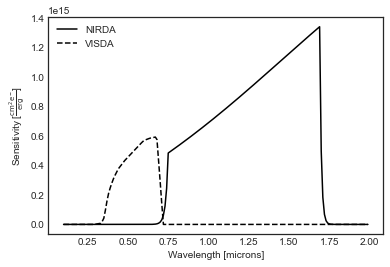

In [43]:
w = np.arange(0.1, 2, 0.01) * u.micron
fig, ax = plt.subplots()
ax.plot(w, nirda.sensitivity(w), label='NIRDA', c='k', ls='-')
ax.plot(w, visda.sensitivity(w), label='VISDA', c='k', ls='--')
ax.set(xlabel='Wavelength [microns]', ylabel=f"Sensitivity [{nirda.sensitivity(w).unit.to_string('latex')}]")
plt.legend()

You can estimate the flux/magnitude of a source

In [44]:
nirda.flux_from_mag(10)

<Quantity 3.63869248e-14 erg / (Angstrom cm2 s)>

In [45]:
visda.flux_from_mag(10)

<Quantity 3.76036826e-13 erg / (Angstrom cm2 s)>

In [50]:
nirda.mag_from_flux(1e-15 * u.erg/(u.AA * u.s * u.cm**2))

<Quantity 13.90236338>

In [51]:
visda.mag_from_flux(1e-15 * u.erg/(u.AA * u.s * u.cm**2))

<Quantity 16.43807595>

Detector have properties

In [54]:
visda.dark

<Quantity 2. electron / s>

In [55]:
visda.read_noise

<Quantity 2.1 electron>

## ADD NIRDA PROPERTIES

You can take a look at the PSFs and PRFs for each detector with the `diagnose` function

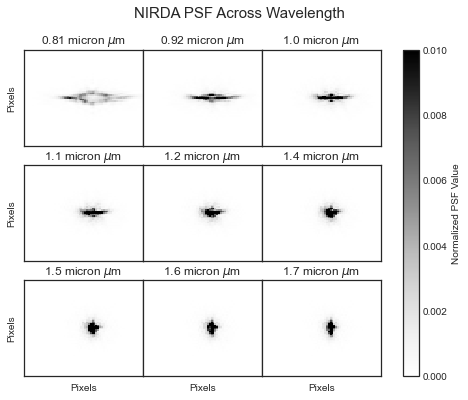

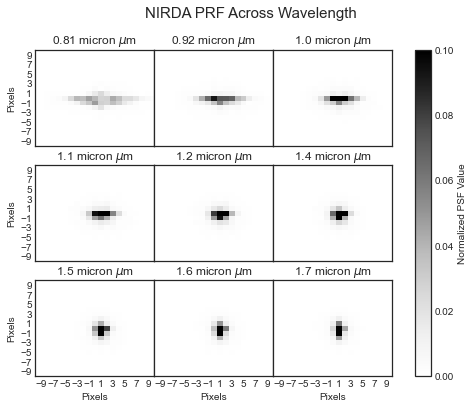

In [40]:
nirda.diagnose(n=3, image_type='psf');
nirda.diagnose(n=3, image_type='prf');

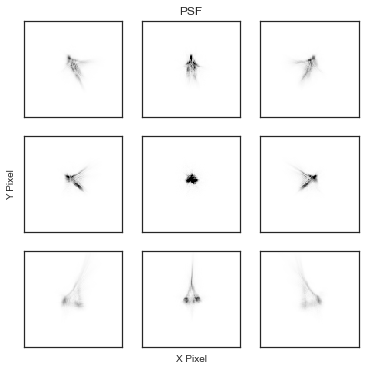

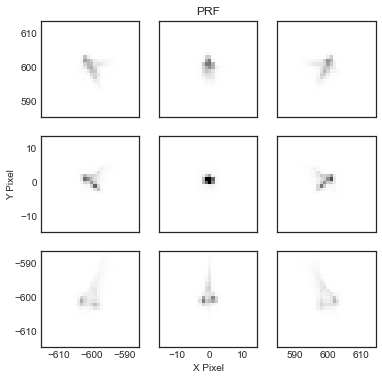

In [41]:
visda.diagnose(n=3, image_type='psf');
visda.diagnose(n=3, image_type='prf');

## Targets

To make simulations you'll need targets with information about the SED. You can get those either using:


In [173]:
target = ps.Target('GJ 436').from_vizier()

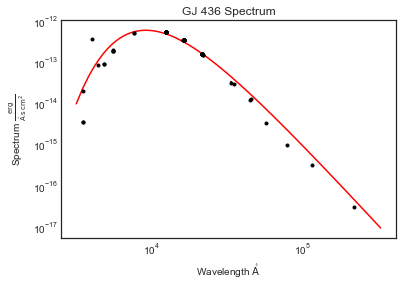

In [174]:
target.plot_spectrum();

or

In [175]:
target = ps.Target('GJ 436').from_phoenix()

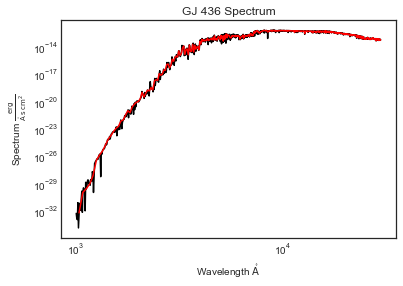

In [176]:
target.plot_spectrum();

`targets` have some helpful attributes including

In [177]:
target.ra

175.54622244662

In [178]:
target.dec

26.706571692

In [179]:
target.teff

3456.0

In [180]:
target.jmag

6.900000095367432

In [184]:
target.tmag

8.402999877929688

## Making Visible Image Simulations

To make image simulations you need to point the observatory at a target and get the sky catalog

In [533]:
target = ps.Target('HAT-P-19').from_phoenix()

In [537]:
target.planets['b']['pl_orbper']

<Quantity 4.008778 d>

In [530]:
source_catalog = p.get_sky_catalog(target.ra, target.dec)

In [306]:
source_catalog.head()

,ra,dec,mag,vis_x,vis_y,nir_x,nir_y,vis_counts,vis_flux
0,9.516723,34.711542,13.0889,1024.000000,1024.000000,1064.000000,2048.000000,34443.387102,2.186102e-14
1,9.539047,34.693664,13.0567,939.285261,941.493870,1008.472692,1993.920352,35480.183120,2.251907e-14
2,9.507223,34.750926,14.1134,1060.025604,1205.774581,1087.613421,2167.146364,13406.204894,8.508840e-15
3,9.498315,34.657354,15.2956,1093.886844,773.906170,1109.808184,1884.072952,4512.589750,2.864115e-15
4,9.506904,34.770621,14.2464,1061.226987,1296.671866,1088.400883,2226.726097,11860.577964,7.527840e-15


In [307]:
len(source_catalog)

46

You can then get an image of the sky on the visible camera

In [323]:
nreads = 4
img = p.get_sky_image(source_catalog, nreads=nreads, include_noise=True)

In [324]:
img.shape

(2048, 2048)

Below is a plot of the VISDA sky image. In future, this will also great a NIRDA image.

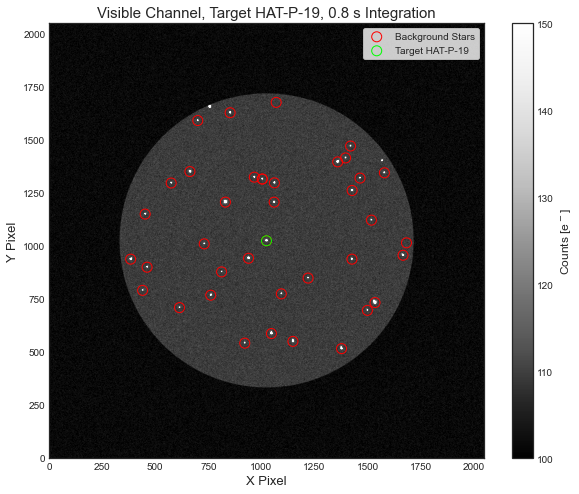

In [366]:
plt.figure(figsize=(10, 8))
plt.imshow(img.value, origin='lower', vmin=100, vmax=150, cmap='Greys_r')
cbar = plt.colorbar()
cbar.set_label('Counts [e$^-$]', fontsize=12)
plt.title(f'Visible Channel, {target}, {visda.integration_time*nreads} Integration', fontsize=15)
plt.xlabel("X Pixel", fontsize=13)
plt.ylabel("Y Pixel", fontsize=13)
k = np.hypot(source_catalog.vis_x - visda.naxis1.value/2, source_catalog.vis_y - visda.naxis2.value/2) < 1320/2
plt.scatter(source_catalog.vis_x[k], source_catalog.vis_y[k], edgecolor='r', facecolor='None', s=100, label='Background Stars')
plt.scatter(source_catalog.vis_x[0], source_catalog.vis_y[0], edgecolor='lime', facecolor='None', s=100, label=f'{target}')
plt.legend(frameon=True)

# Making NIRDA Traces

You can get an example trace of a target on the NIRDA detector using a

In [878]:
wavelength = np.linspace(0.1, 2, 6000) * u.micron
spectrum = target.model_spectrum(wavelength)
trace = nirda.get_trace(wavelength, spectrum, pixel_resolution=2)

[Text(0.5, 0, 'Pixels'), Text(0, 0.5, 'Pixels')]

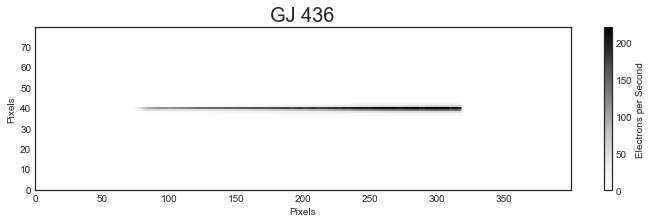

In [879]:
fig, ax = plt.subplots(figsize=(12, 3))
plt.pcolormesh(np.arange(trace.shape[1]), np.arange(trace.shape[0]), trace.value)
cbar = plt.colorbar()
cbar.set_label("Electrons per Second")
plt.title('GJ 436', fontsize=20)
ax.set(xlabel='Pixels', ylabel='Pixels')

# Making realistic data simulations

In [803]:
target = ps.Target('HAT-P-19').from_phoenix()

Find the time baseline for observations

In [872]:
# Set a number of frames
nframes = 40
exptime = nframes * nirda.frame_time
time = np.arange(target.planets['b']['pl_tranmid'].value - 0.3, target.planets['b']['pl_tranmid'].value + 0.3, exptime.to(u.day).value)

# Drop some parts of the orbit because of Earth occultation
c = (90*u.minute).to(u.day).value
time = time[((time % c) > c * 0.3)]
cyc = time - (time % c)
time = time[(cyc != np.unique(cyc)[0]) & (cyc != np.unique(cyc)[-1])]

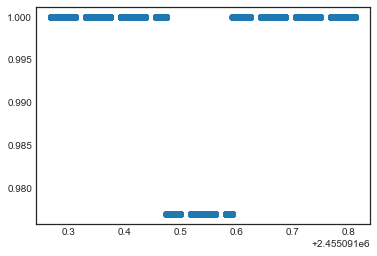

In [873]:
plt.scatter(time, target.box_transit(time))

In [875]:
integration = nirda.get_integration(wavelength, spectrum, nframes=nframes)

100%|███████████████████████████████████████████| 40/40 [00:22<00:00,  1.80it/s]


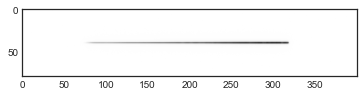

In [876]:
plt.imshow(integration)

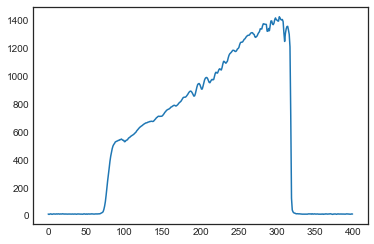

In [877]:
plt.plot(integration[38:42].mean(axis=0))